In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.optimize import curve_fit
import pandas as pd
import matplotlib.gridspec as gridspec
import scipy.stats as stats
from scipy.signal import savgol_filter
import seaborn as sns
%matplotlib inline
pd.set_option('expand_frame_repr', False)

In [2]:
def line(x, a, b):
    return a*x + b

def processData(data, n_simuls, com):
    split = np.array_split(data, n_simuls)
    dpt = np.subtract(split, com)
    m = np.mean(dpt, axis=0)
    msd = np.var(dpt, axis=0)
    return split, dpt, m, msd

In [3]:
data_500_l1 = np.loadtxt('./Data/com-500_l1.dat')
data_500_l2 = np.loadtxt('./Data/com-500_l2.dat')
data_500_l3 = np.loadtxt('./Data/com-500_l3.dat')
data_500_l4 = np.loadtxt('./Data/com-500_l4.dat')
data_500_l5 = np.loadtxt('./Data/com-500_l5.dat')

In [4]:
data_500 = np.vstack((data_500_l1, data_500_l2, data_500_l3, data_500_l4, data_500_l5))
split_500, dpt_500, m_500, msd_500 = processData(data_500, 1280, 500)

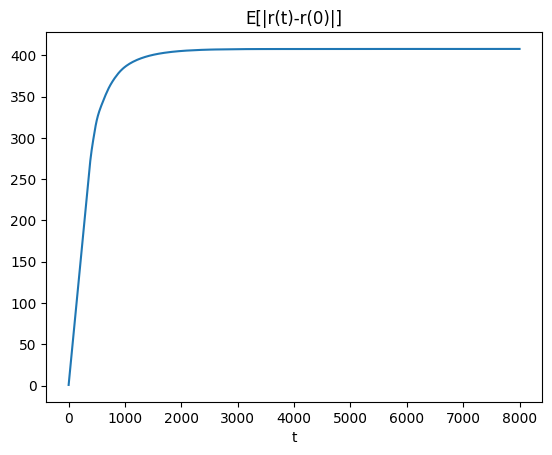

In [5]:
ev = np.linalg.norm(m_500, axis=1)
plt.plot(ev)
plt.title('E[|r(t)-r(0)|]')
plt.xlabel('t')
plt.show()

From which we can see conclude an equilibrium is reached. From the graph, its slope might be of interest

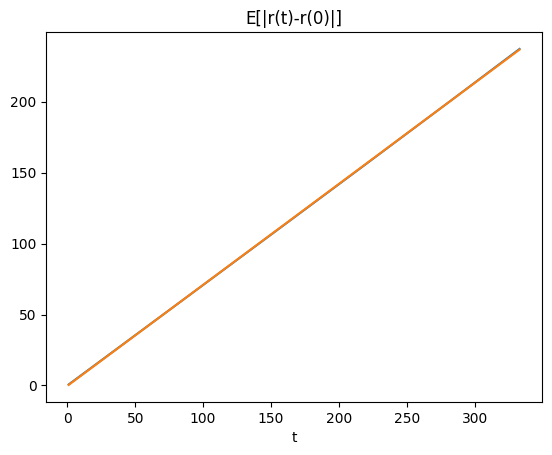

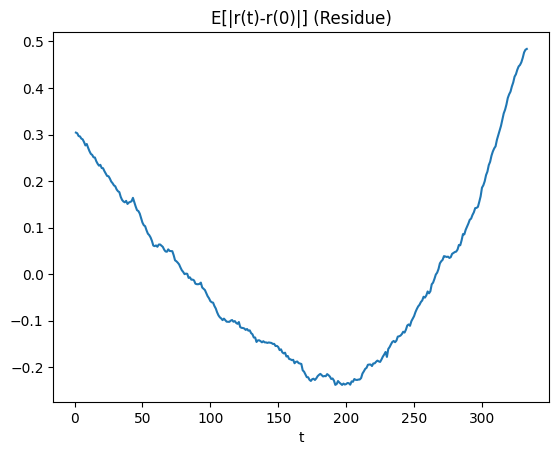

Fit is given by y = 0.7118221218071823x + -0.30948002807347197


In [6]:
x = np.linspace(1, 8000, 8000)[:333]
y = ev[:333]

popt, pcov = curve_fit(line, x, y)
plt.plot(x, y)
plt.plot(x, line(x, *popt))
plt.title('E[|r(t)-r(0)|]')
plt.xlabel('t')
plt.show()
plt.plot(x, y-line(x, *popt))
plt.title('E[|r(t)-r(0)|] (Residue)')
plt.xlabel('t')
plt.show()
print(f'Fit is given by y = {popt[0]}x + {popt[1]}')

So the average speed is around 0.71.

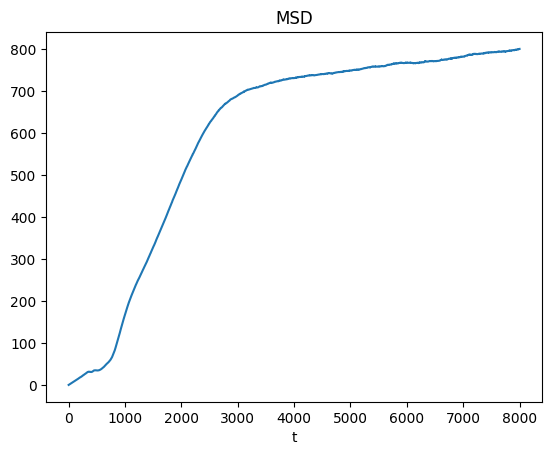

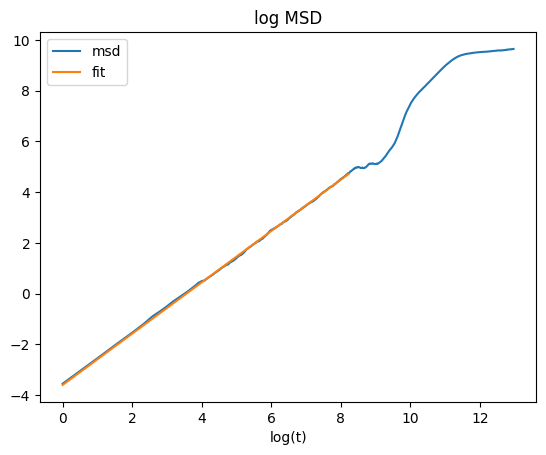

Fit is given by y = 1.0115800260410697x + -3.6018395021869662


In [7]:
msd = msd_500[:, 0] + msd_500[:, 1]
x = np.linspace(1, 8000, 8000)
y = msd
plt.plot(x, y)
plt.title('MSD')
plt.xlabel('t')
plt.show()

x = np.log2(np.linspace(1, 8000, 8000))
y = np.log2(msd)
popt, pcov = curve_fit(line, x[:300], y[:300])
plt.plot(x, y, label='msd')
plt.plot(x[:300], line(x[:300], *popt), label='fit')
plt.title('log MSD')
plt.xlabel('log(t)')
plt.legend()
plt.show()
print(f'Fit is given by y = {popt[0]}x + {popt[1]}')

So the 'spread' behaves diffussively. We will calculate the diffusivity from the graph.
To do so, use 4Dt = MSD, so D = MSD/4.

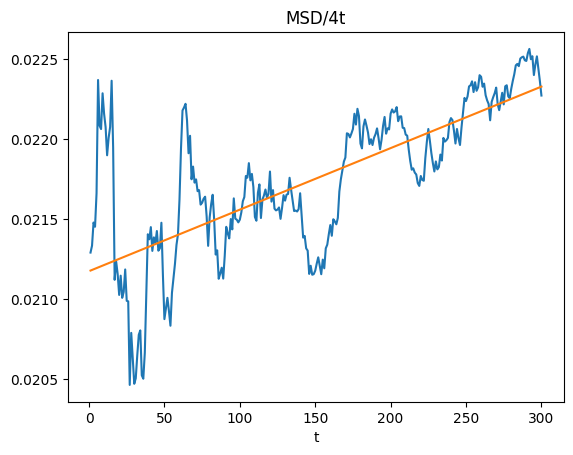

Fit is given by y = 3.844815545573914e-06x + 0.021173198861545714


In [8]:
x = np.linspace(1, 8000, 8000)[:300]
y = np.divide(msd[:300], 4*x)

popt, pcov = curve_fit(line, x, y)
plt.plot(x, y)
plt.plot(x, line(x, *popt))
plt.title('MSD/4t')
plt.xlabel('t')
plt.show()
print(f'Fit is given by y = {popt[0]}x + {popt[1]}')

So D ~ 0.021, and we will **assume** it's constant

Around step 3000, the behaviour changes. We will now look into it.

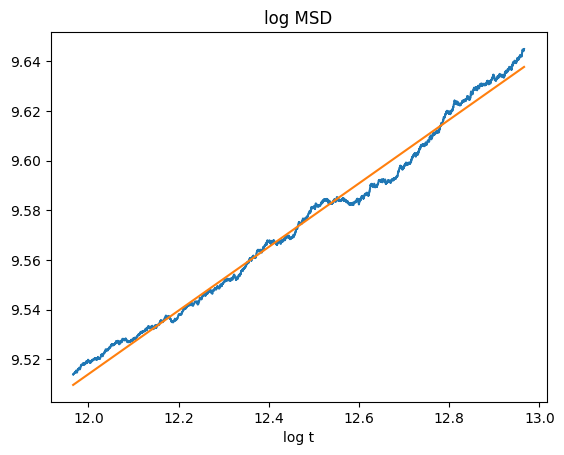

Fit is given by y = 0.1280525302699218x + 7.9774501311776
MSD = t^0.1280525302699218 * 252.02973245478546


In [9]:
x = np.log2(np.linspace(1, 8000, 8000))[4000:8000]
y = np.log2(msd)[4000:8000]
plt.title('log MSD')
plt.xlabel('log t')
plt.plot(x, y)
popt, pcov = curve_fit(line, x, y)
plt.plot(x, line(x, *popt))
plt.show()
print(f'Fit is given by y = {popt[0]}x + {popt[1]}')
print(f'MSD = t^{popt[0]} * {2**popt[1]}')

In any case, the exponent is less than 1, so the system is confined. 

For the middle section, we will calculate the gradient of the log-log function to determine the exponent

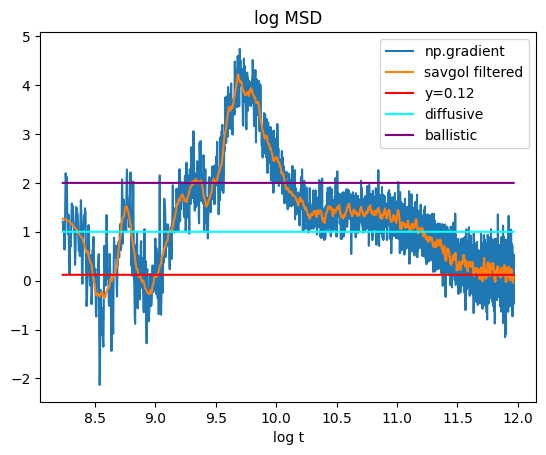

In [10]:
x = np.log2(np.linspace(1, 8000, 8000))[300:4000]
y = np.log2(msd)[300:4000]
gradient = np.gradient(y, x)
plt.plot(x, gradient, label='np.gradient')
smooth = savgol_filter(gradient, 51, 2)
plt.plot(x, smooth, label='savgol filtered')
plt.plot(x, np.zeros(x.size)+0.12, color='red', label='y=0.12')
plt.plot(x, np.zeros(x.size)+1, label='diffusive', color='cyan')
plt.plot(x, np.zeros(x.size)+2, label='ballistic', color='purple')
plt.title('log MSD')
plt.xlabel('log t')
plt.legend()
plt.show()

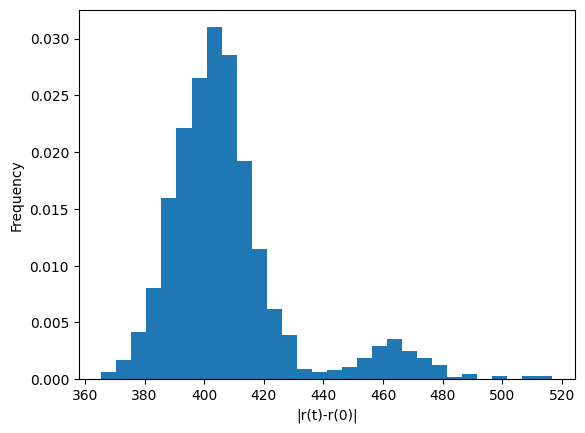

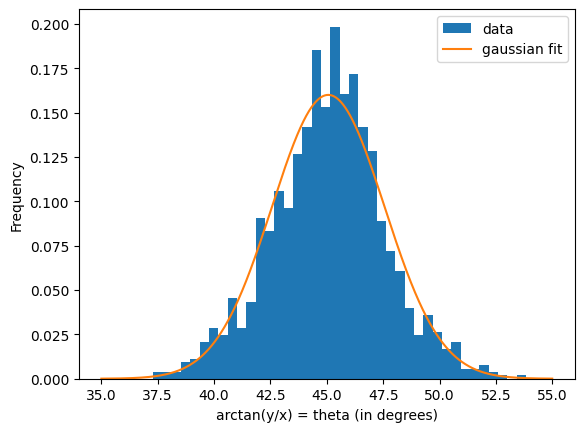

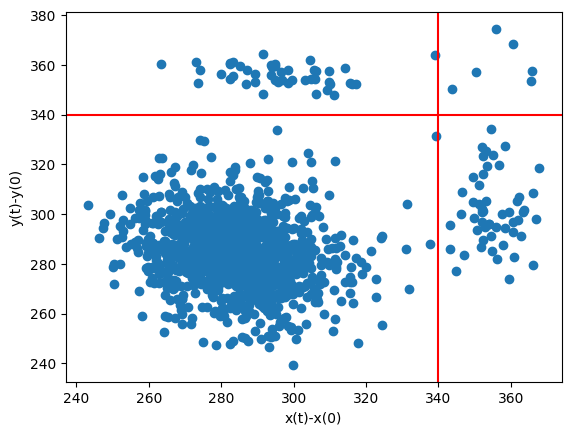

In [11]:
fin_500 = np.subtract(data_500[7999::8000], 500)
plt.hist(np.linalg.norm(fin_500, axis=1), 30, density=True)
plt.xlabel('|r(t)-r(0)|')
plt.ylabel('Frequency')
plt.show()

angles = np.arctan2(fin_500[:, 1], fin_500[:, 0])*180/np.pi
mu = np.mean(angles)
sigma = np.std(angles)
x = np.linspace(35, 55, 1000)
plt.hist(angles, 40, density=True, label='data')
plt.xlabel('arctan(y/x) = theta (in degrees)')
plt.ylabel('Frequency')
plt.plot(x, stats.norm.pdf(x, mu, sigma), label='gaussian fit')
plt.legend()
plt.show()

plt.scatter(fin_500[:,0], fin_500[:, 1])
plt.xlabel('x(t)-x(0)')
plt.ylabel('y(t)-y(0)')
plt.axhline(y=340, color='r')
plt.axvline(x=340, color='r')
plt.show()

In [12]:
df = pd.DataFrame(fin_500, columns=['x', 'y'])
df.describe()

,x,y
count,1280.000000,1280.000000
mean,287.920160,288.553509
std,20.228468,19.800671
min,243.271609,239.397225
25%,276.083582,277.354485
50%,285.795815,286.205035
75%,294.587264,296.381854
max,367.826517,374.523115


In [13]:
len(df.loc[(df['x'] > 340) & (df['y'] > 340)])/12.8 # Returns a value out of 100

0.46875

In [14]:
len(df.loc[(df['x'] < 340) & (df['y'] > 340)])/12.8

3.59375

In [15]:
len(df.loc[(df['x'] > 340) & (df['y'] < 340)])/12.8

4.140625

In [16]:
len(df.loc[(df['x'] < 340) & (df['y'] < 340)])/12.8

91.796875

We repeat measurements for different values of v_p and v_d. Starting with v_d = 0.75 v_p = 1

In [17]:
data_v075 = np.loadtxt('./Data/com-d075.dat')
data_v050 = np.loadtxt('./Data/com-d050.dat')

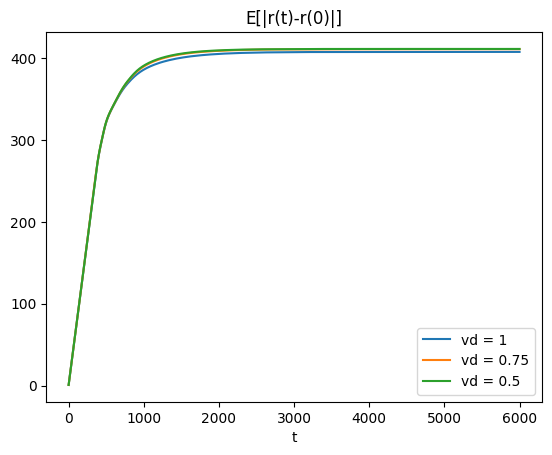

In [18]:
split_v075, dpt_v075, m_v075, msd_v075 = processData(data_v075, 1024, 500)
split_v050, dpt_v050, m_v050, msd_v050 = processData(data_v050, 1024, 500)

ev = np.linalg.norm(m_500[:6000], axis=1)
plt.plot(ev, label='vd = 1')
ev075 = np.linalg.norm(m_v075, axis=1)
plt.plot(ev075, label='vd = 0.75')
ev050 = np.linalg.norm(m_v050, axis=1)
plt.plot(ev050, label='vd = 0.5')
plt.title('E[|r(t)-r(0)|]')
plt.xlabel('t')
plt.legend()
plt.show()

Take the difference to check how equal they actually are

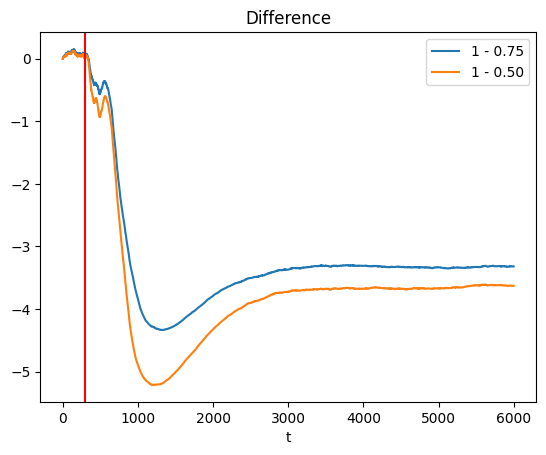

Final difference, 0.75: -3.3208705911476954
Final difference, 0.50: -3.6300799267286266


In [19]:
plt.plot(ev-ev075, label='1 - 0.75')
plt.plot(ev-ev050, label='1 - 0.50')
plt.title('Difference')
plt.xlabel('t')
plt.axvline(x=300, color='r')
plt.legend()
plt.show()
print(f'Final difference, 0.75: {(ev-ev075)[-1]}')
print(f'Final difference, 0.50: {(ev-ev050)[-1]}')

So, on average, the lower v_d system reached dr = 3.32 units further for dv = -0.25. The first steps are largely unchanged

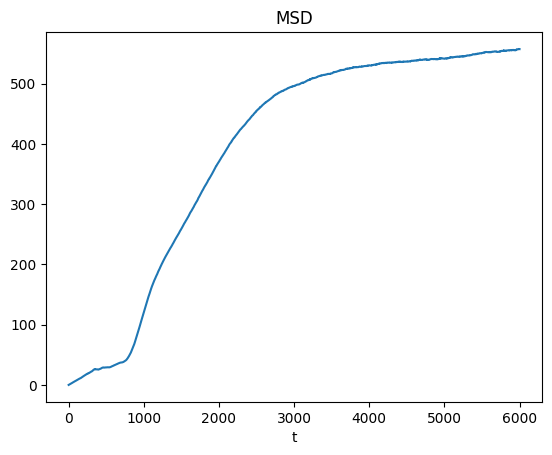

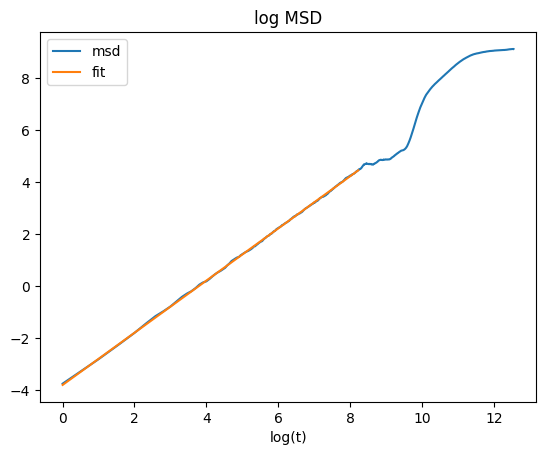

Fit is given by y = 1.002941199544377x + -3.7991920931162033


In [20]:
msd = msd_v075[:, 0] + msd_v075[:, 1]
x = np.linspace(1, 6000, 6000)
y = msd
plt.plot(x, y)
plt.title('MSD')
plt.xlabel('t')
plt.show()

x = np.log2(np.linspace(1, 6000, 6000))
y = np.log2(msd)
popt, pcov = curve_fit(line, x[:300], y[:300])
plt.plot(x, y, label='msd')
plt.plot(x[:300], line(x[:300], *popt), label='fit')
plt.title('log MSD')
plt.xlabel('log(t)')
plt.legend()
plt.show()
print(f'Fit is given by y = {popt[0]}x + {popt[1]}')

Final difference - 0.75: 210.9187658244134
Final difference - 0.50: 317.54047457797947


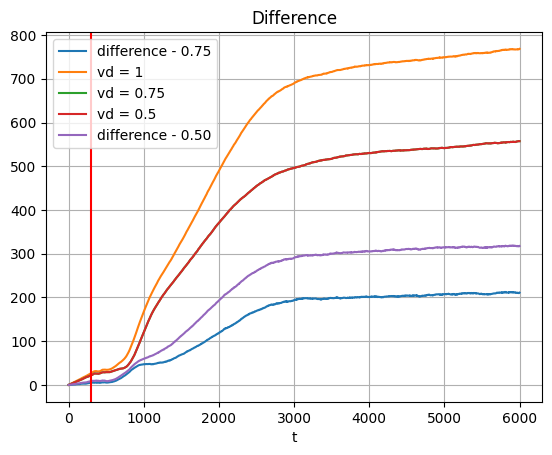

In [21]:
msd1 = (msd_500[:, 0] + msd_500[:, 1])[:6000]
msd075 = msd_v075[:, 0] + msd_v075[:, 1]
plt.plot(msd1-msd075, label='difference - 0.75')
plt.plot(msd1, label='vd = 1')
plt.plot(msd075, label='vd = 0.75')
print(f'Final difference - 0.75: {(msd1-msd075)[-1]}')
msd050 = msd_v050[:, 0] + msd_v050[:, 1]
plt.plot(msd, label='vd = 0.5')
plt.plot(msd1-msd050, label='difference - 0.50')
plt.title('Difference')
plt.xlabel('t')
plt.axvline(x=300, color='r')
plt.legend()
plt.grid()
print(f'Final difference - 0.50: {(msd1-msd050)[-1]}')
plt.show()


So the lower vd systems 'spread' less on average. This is to be expected. For dv = -0.25, have d(msd) = -210.91

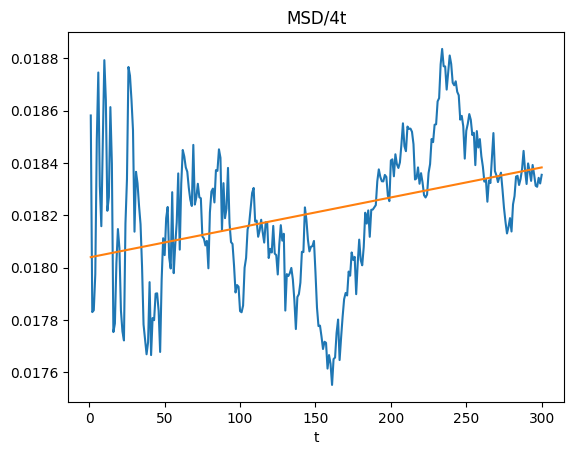

Fit is given by y = 1.147547523526544e-06x + 0.018038661865762643


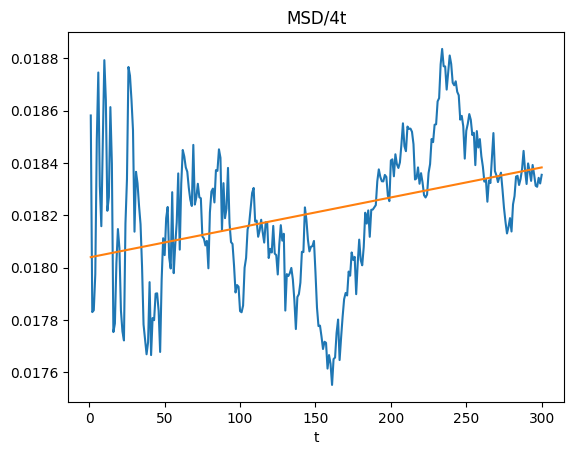

Fit is given by y = 1.147547523526544e-06x + 0.018038661865762643


In [22]:
x = np.linspace(1, 8000, 8000)[:300]
y = np.divide(msd075[:300], 4*x)

popt, pcov = curve_fit(line, x, y)
plt.plot(x, y)
plt.plot(x, line(x, *popt))
plt.title('MSD/4t')
plt.xlabel('t')
plt.show()
print(f'Fit is given by y = {popt[0]}x + {popt[1]}')

x = np.linspace(1, 8000, 8000)[:300]
y = np.divide(msd075[:300], 4*x)

popt, pcov = curve_fit(line, x, y)
plt.plot(x, y)
plt.plot(x, line(x, *popt))
plt.title('MSD/4t')
plt.xlabel('t')
plt.show()
print(f'Fit is given by y = {popt[0]}x + {popt[1]}')

So D ~ 0.018, well lower v_d so nothing too out of the norm here either. dv = -0.25 dD = -0.03

We skip the middle section and final section and focus on the final state. (Middle section too complicated, final section looks around the same)

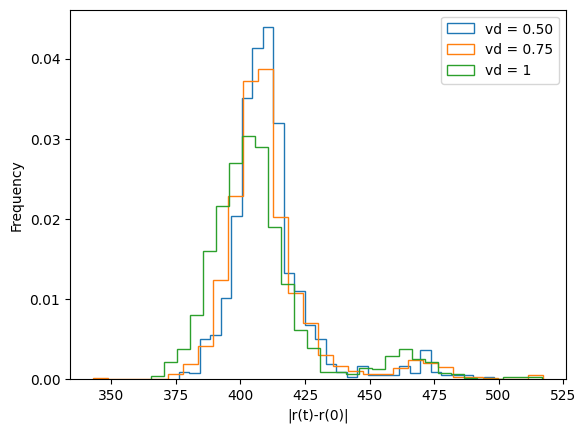

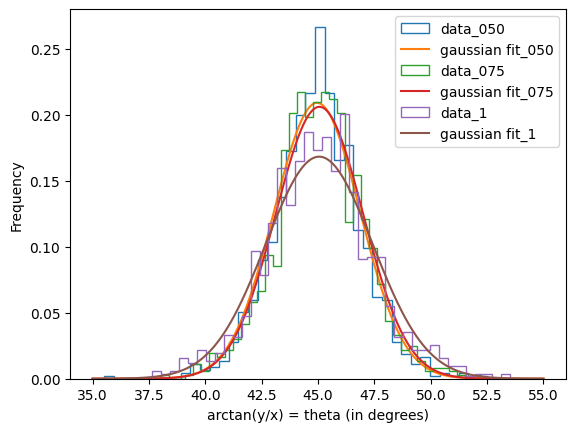

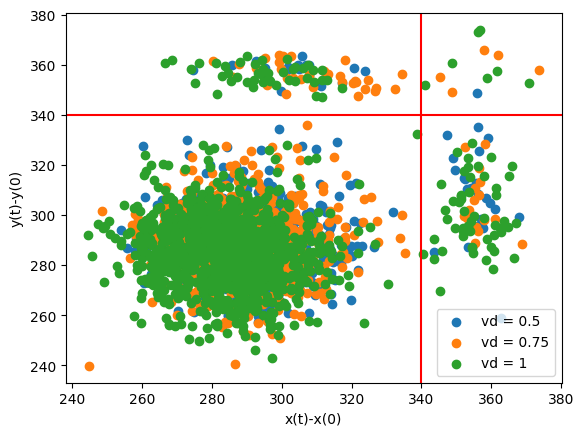

STD difference - 0.75:  0.43467098117958414
STD difference - 0.50:  0.4628065682542293


In [23]:
fin_500 = np.subtract(data_500[5999::8000], 500) # vd = 1
fin_v075 = np.subtract(data_v075[5999::6000], 500)
fin_v050 = np.subtract(data_v050[5999::6000], 500)
plt.hist(np.linalg.norm(fin_v050, axis=1), 30, density=True, histtype='step', label='vd = 0.50')
plt.hist(np.linalg.norm(fin_v075, axis=1), 30, density=True, histtype='step', label='vd = 0.75')
plt.hist(np.linalg.norm(fin_500, axis=1), 30, density=True, histtype='step', label='vd = 1')
plt.legend()
plt.xlabel('|r(t)-r(0)|')
plt.ylabel('Frequency')
plt.show()

angles050 = np.arctan2(fin_v050[:, 1], fin_v050[:, 0])*180/np.pi
mu = np.mean(angles050)
sigma = np.std(angles050)
x = np.linspace(35, 55, 1000)
plt.hist(angles050, 40, density=True, label='data_050', histtype='step')
plt.xlabel('arctan(y/x) = theta (in degrees)')
plt.ylabel('Frequency')
plt.plot(x, stats.norm.pdf(x, mu, sigma), label='gaussian fit_050')

angles075 = np.arctan2(fin_v075[:, 1], fin_v075[:, 0])*180/np.pi
mu = np.mean(angles075)
sigma = np.std(angles075)
x = np.linspace(35, 55, 1000)
plt.hist(angles075, 40, density=True, label='data_075', histtype='step')
plt.xlabel('arctan(y/x) = theta (in degrees)')
plt.ylabel('Frequency')
plt.plot(x, stats.norm.pdf(x, mu, sigma), label='gaussian fit_075')

angles1 = np.arctan2(fin_500[:, 1], fin_500[:, 0])*180/np.pi
mu = np.mean(angles1)
sigma = np.std(angles1)
x = np.linspace(35, 55, 1000)
plt.hist(angles1, 40, density=True, label='data_1', histtype='step')
plt.plot(x, stats.norm.pdf(x, mu, sigma), label='gaussian fit_1')
plt.legend()
plt.show()

plt.scatter(fin_v050[:,0], fin_v050[:, 1], label='vd = 0.5')
plt.scatter(fin_v075[:,0], fin_v075[:, 1], label='vd = 0.75')
plt.scatter(fin_500[:,0], fin_500[:, 1], label='vd = 1')
plt.xlabel('x(t)-x(0)')
plt.ylabel('y(t)-y(0)')
plt.axhline(y=340, color='r')
plt.axvline(x=340, color='r')
plt.legend()
plt.show()
print(f'STD difference - 0.75:  {np.std(angles1)-np.std(angles075)}')
print(f'STD difference - 0.50:  {np.std(angles1)-np.std(angles050)}')

So dv = -0.25 leads to d(std) = -0.43 in angles.

We compute the gradient in order to find any 'phase differences'. (on the log-log graph of msd)

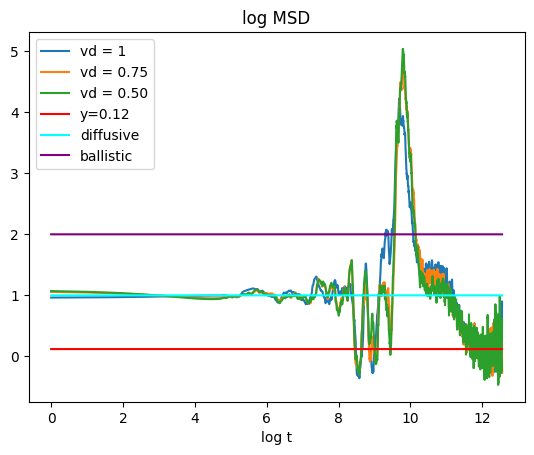

In [24]:
msd1 = (msd_500[:, 0] + msd_500[:, 1])[:6000]
msd075 = msd_v075[:, 0] + msd_v075[:, 1]
msd050 = msd_v050[:, 0] + msd_v050[:, 1]
x = np.log2(np.linspace(1, 6000, 6000))
y = np.log2(msd1)
gradient = np.gradient(y, x)
smooth075 = savgol_filter(gradient, 51, 2)
plt.plot(x, smooth075, label='vd = 1')

y = np.log2(msd075)
gradient = np.gradient(y, x)
smooth1 = savgol_filter(gradient, 51, 2)
plt.plot(x, smooth1, label='vd = 0.75')

y = np.log2(msd050)
gradient = np.gradient(y, x)
smooth050 = savgol_filter(gradient, 51, 2)
plt.plot(x, smooth050, label='vd = 0.50')

plt.plot(x, np.zeros(x.size)+0.12, color='red', label='y=0.12')
plt.plot(x, np.zeros(x.size)+1, label='diffusive', color='cyan')
plt.plot(x, np.zeros(x.size)+2, label='ballistic', color='purple')
plt.title('log MSD')
plt.xlabel('log t')
plt.legend()
plt.show()

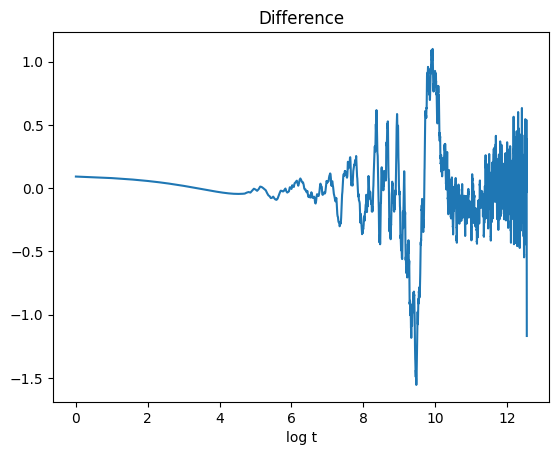

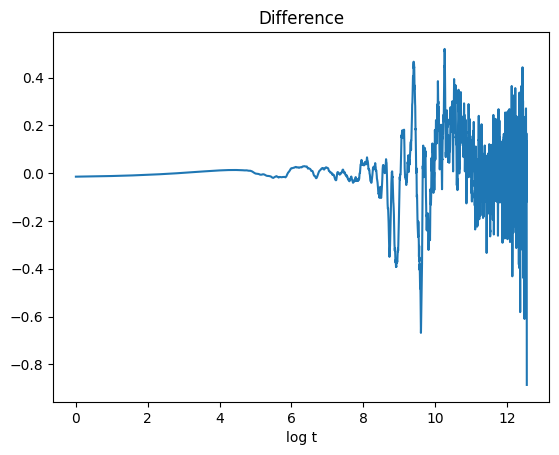

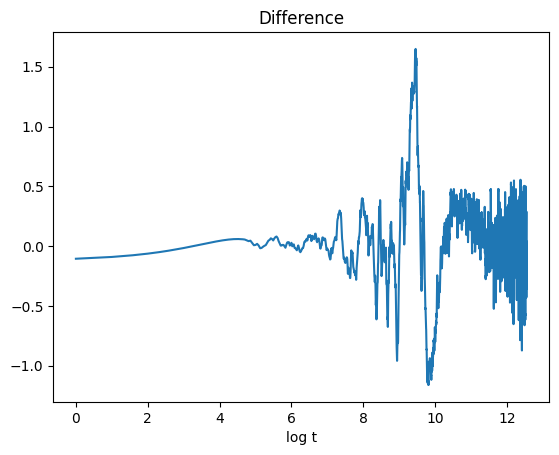

In [25]:
plt.plot(x, smooth1-smooth075)
plt.title('Difference')
plt.xlabel('log t')
plt.show()
plt.plot(x, smooth1-smooth050)
plt.title('Difference')
plt.xlabel('log t')
plt.show()
plt.plot(x, smooth075-smooth050)
plt.title('Difference')
plt.xlabel('log t')
plt.show()

Hard to tell but it looks like no difference to me.

My conclusion: diffusion makes no difference aside from the spread.

In [26]:
data_p4 = np.loadtxt('./Data/com-p4.dat')
data_p2 = np.loadtxt('./Data/com-p2.dat')
data_p8 = np.loadtxt('./Data/com-p8.dat')

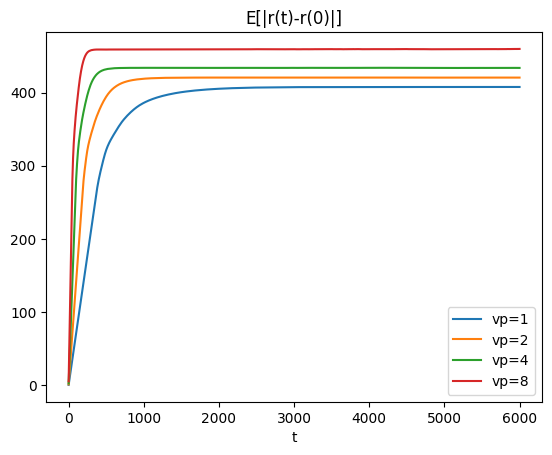

In [27]:
split_p4 = np.array_split(data_p4, 1024)
dpt_p4 = np.subtract(split_p4, 500)
m_p4 = np.mean(dpt_p4, axis=0)
msd_p4 = np.var(dpt_p4, axis=0)

split_p2 = np.array_split(data_p2, 1024)
dpt_p2 = np.subtract(split_p2, 500)
m_p2 = np.mean(dpt_p2, axis=0)
msd_p2 = np.var(dpt_p2, axis=0)

split_p8 = np.array_split(data_p8, 1024)
dpt_p8 = np.subtract(split_p8, 500)
m_p8 = np.mean(dpt_p8, axis=0)
msd_p8 = np.var(dpt_p8, axis=0)

ev = np.linalg.norm(m_500, axis=1)[:6000]
plt.plot(ev, label='vp=1')
plt.title('E[|r(t)-r(0)|]')
plt.xlabel('t')

ev = np.linalg.norm(m_p2, axis=1)
plt.plot(ev, label='vp=2')
plt.title('E[|r(t)-r(0)|]')
plt.xlabel('t')

ev = np.linalg.norm(m_p4, axis=1)
plt.plot(ev, label='vp=4')
plt.title('E[|r(t)-r(0)|]')
plt.xlabel('t')

ev = np.linalg.norm(m_p8, axis=1)
plt.plot(ev, label='vp=8')
plt.title('E[|r(t)-r(0)|]')
plt.xlabel('t')
plt.legend()
plt.show()

So the system goes through phases quicker as the persitance increases.

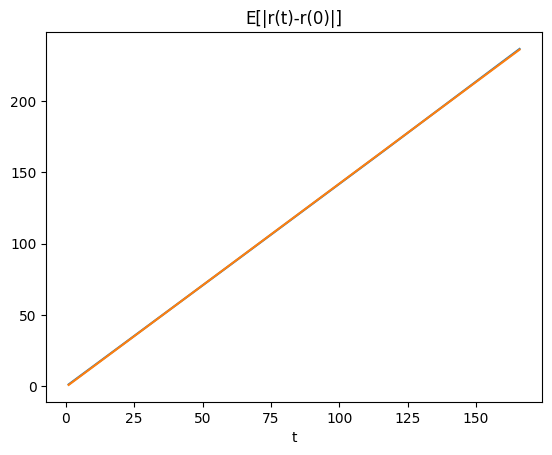

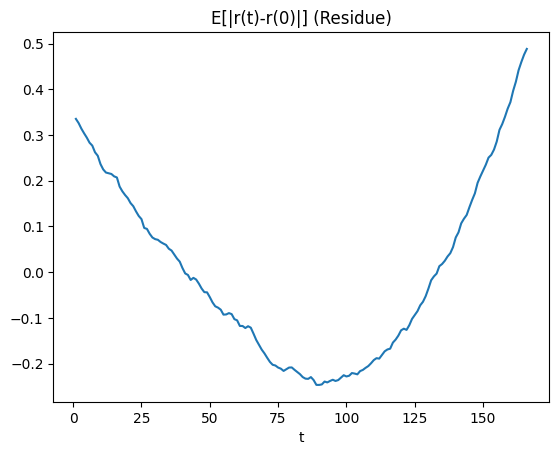

Fit is given by y = 1.4239957679972732x + -0.33784866314462736


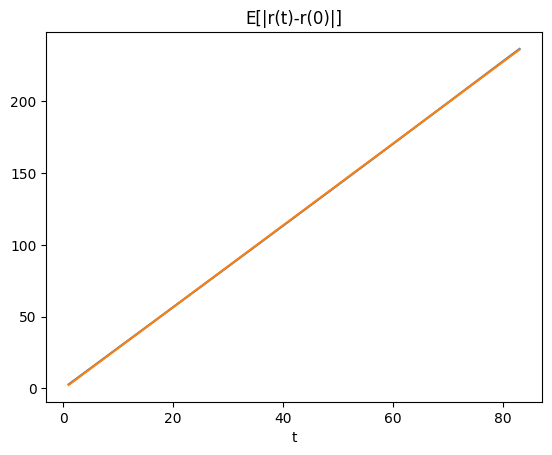

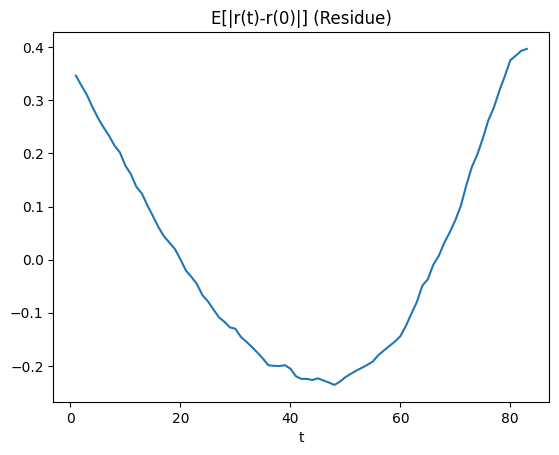

Fit is given by y = 2.8490423434613823x + -0.3711308591914624


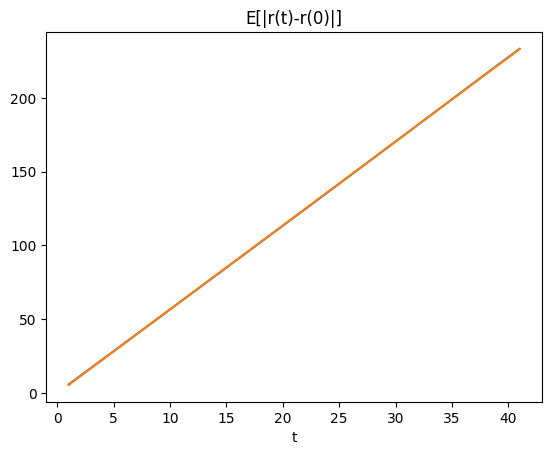

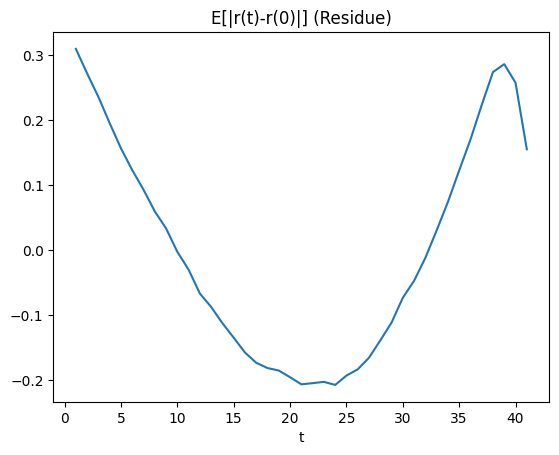

Fit is given by y = 5.696579590986252x + -0.35296070176227357


In [28]:
ev = np.linalg.norm(m_p2, axis=1)
x = np.linspace(1, 8000, 8000)[:166]
y = ev[:166]

popt, pcov = curve_fit(line, x, y)
plt.plot(x, y)
plt.plot(x, line(x, *popt))
plt.title('E[|r(t)-r(0)|]')
plt.xlabel('t')
plt.show()
plt.plot(x, y-line(x, *popt))
plt.title('E[|r(t)-r(0)|] (Residue)')
plt.xlabel('t')
plt.show()
print(f'Fit is given by y = {popt[0]}x + {popt[1]}')

ev = np.linalg.norm(m_p4, axis=1)
x = np.linspace(1, 8000, 8000)[:83]
y = ev[:83]

popt, pcov = curve_fit(line, x, y)
plt.plot(x, y)
plt.plot(x, line(x, *popt))
plt.title('E[|r(t)-r(0)|]')
plt.xlabel('t')
plt.show()
plt.plot(x, y-line(x, *popt))
plt.title('E[|r(t)-r(0)|] (Residue)')
plt.xlabel('t')
plt.show()
print(f'Fit is given by y = {popt[0]}x + {popt[1]}')

ev = np.linalg.norm(m_p8, axis=1)
x = np.linspace(1, 8000, 8000)[:41]
y = ev[:41]

popt, pcov = curve_fit(line, x, y)
plt.plot(x, y)
plt.plot(x, line(x, *popt))
plt.title('E[|r(t)-r(0)|]')
plt.xlabel('t')
plt.show()
plt.plot(x, y-line(x, *popt))
plt.title('E[|r(t)-r(0)|] (Residue)')
plt.xlabel('t')
plt.show()
print(f'Fit is given by y = {popt[0]}x + {popt[1]}')

Ordered 2-4-8. 
So it satisfies the hypothesis that |v| = sqrt(vp^2 + vp^2)/2. And time that t_p1 = 333/vp. 333.

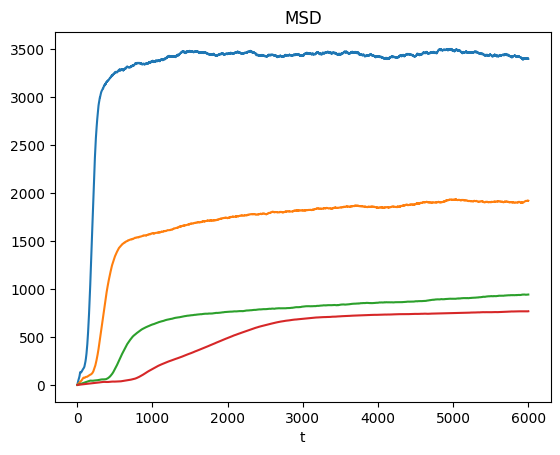

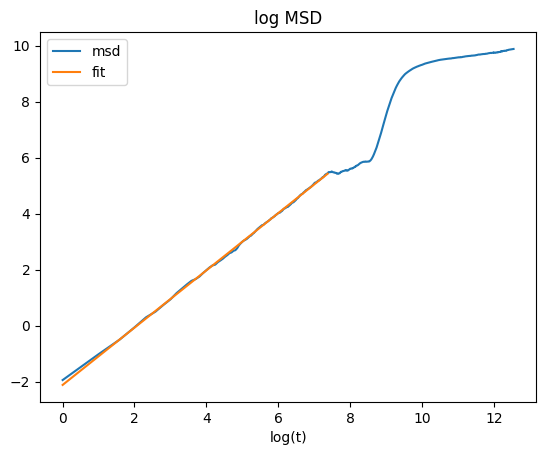

Fit is given by y = 1.0225484576565054x + -2.117698017370828


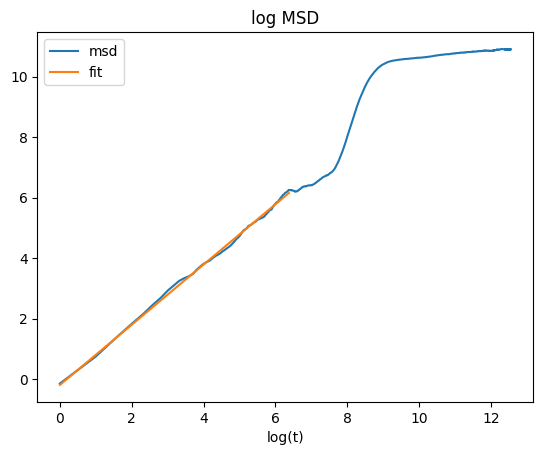

Fit is given by y = 0.9960489727718189x + -0.196270951704693


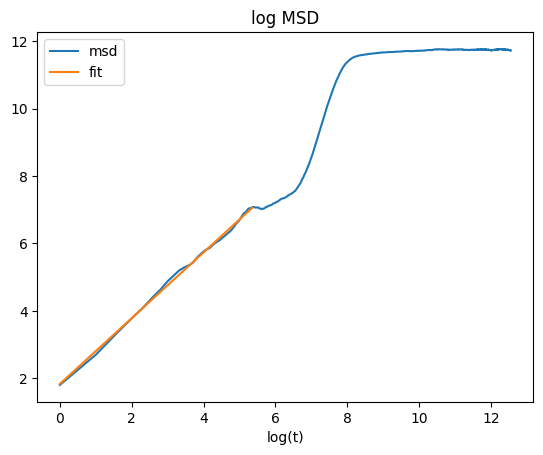

Fit is given by y = 0.9760753480897244x + 1.832727886859543


In [29]:
msd = msd_p8[:, 0] + msd_p8[:, 1]
x = np.linspace(1, 6000, 6000)
y = msd
plt.plot(x, y)
plt.title('MSD')
plt.xlabel('t')

msd = msd_p4[:, 0] + msd_p4[:, 1]
x = np.linspace(1, 6000, 6000)
y = msd
plt.plot(x, y)
plt.title('MSD')
plt.xlabel('t')

msd = msd_p2[:, 0] + msd_p2[:, 1]
x = np.linspace(1, 6000, 6000)
y = msd
plt.plot(x, y)
plt.title('MSD')
plt.xlabel('t')

msd = msd_500[:, 0][:6000] + msd_500[:, 1][:6000]
x = np.linspace(1, 8000, 8000)[:6000]
y = msd
plt.plot(x, y)
plt.title('MSD')
plt.xlabel('t')

plt.show()

msd = msd_p2[:, 0] + msd_p2[:, 1]
x = np.log2(np.linspace(1, 6000, 6000))
y = np.log2(msd)
popt, pcov = curve_fit(line, x[:166], y[:166])
plt.plot(x, y, label='msd')
plt.plot(x[:166], line(x[:166], *popt), label='fit')
plt.title('log MSD')
plt.xlabel('log(t)')
plt.legend()
plt.show()
print(f'Fit is given by y = {popt[0]}x + {popt[1]}')


msd = msd_p4[:, 0] + msd_p4[:, 1]
x = np.log2(np.linspace(1, 6000, 6000))
y = np.log2(msd)
popt, pcov = curve_fit(line, x[:83], y[:83])
plt.plot(x, y, label='msd')
plt.plot(x[:83], line(x[:83], *popt), label='fit')
plt.title('log MSD')
plt.xlabel('log(t)')
plt.legend()
plt.show()
print(f'Fit is given by y = {popt[0]}x + {popt[1]}')

msd = msd_p8[:, 0] + msd_p8[:, 1]
x = np.log2(np.linspace(1, 6000, 6000))
y = np.log2(msd)
popt, pcov = curve_fit(line, x[:41], y[:41])
plt.plot(x, y, label='msd')
plt.plot(x[:41], line(x[:41], *popt), label='fit')
plt.title('log MSD')
plt.xlabel('log(t)')
plt.legend()
plt.show()
print(f'Fit is given by y = {popt[0]}x + {popt[1]}')


All the fits are lineal with slope 1. So diffussive.

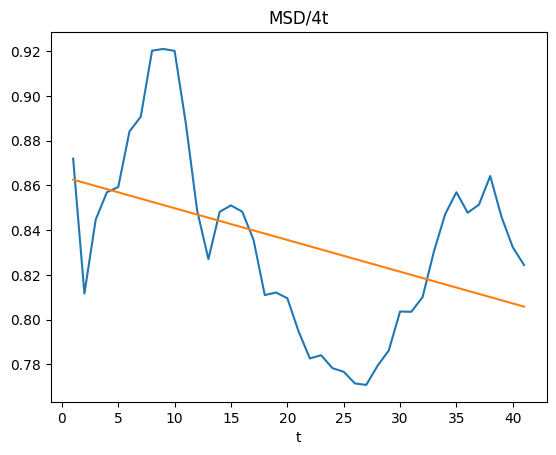

Fit is given by y = -0.0014195882612082489x + 0.8639910953920567


In [30]:
msd = msd_p8[:, 0] + msd_p8[:, 1]
x = np.linspace(1, 8000, 8000)[:41]
y = np.divide(msd[:41], 4*x)

popt, pcov = curve_fit(line, x, y)
plt.plot(x, y)
plt.plot(x, line(x, *popt))
plt.title('MSD/4t')
plt.xlabel('t')
plt.show()
print(f'Fit is given by y = {popt[0]}x + {popt[1]}')

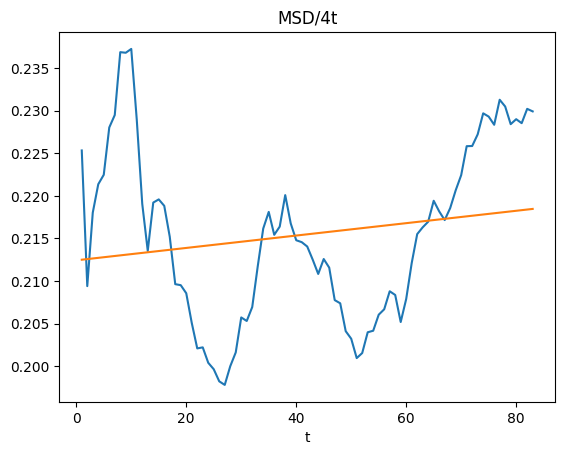

Fit is given by y = 7.273699241416853e-05x + 0.21242643844158937


In [31]:
msd = msd_p4[:, 0] + msd_p4[:, 1]
x = np.linspace(1, 8000, 8000)[:83]
y = np.divide(msd[:83], 4*x)

popt, pcov = curve_fit(line, x, y)
plt.plot(x, y)
plt.plot(x, line(x, *popt))
plt.title('MSD/4t')
plt.xlabel('t')
plt.show()
print(f'Fit is given by y = {popt[0]}x + {popt[1]}')

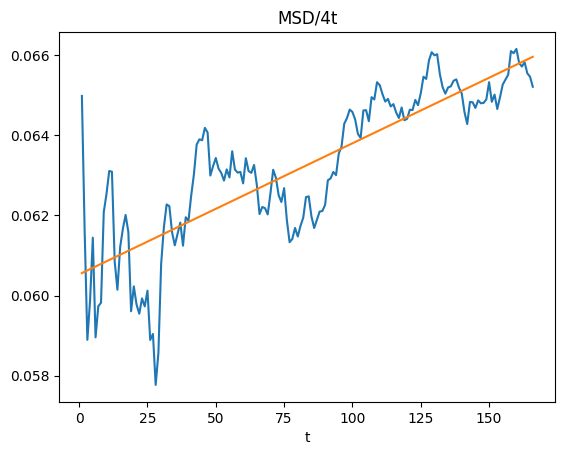

Fit is given by y = 3.271199468234772e-05x + 0.06052695596181626


In [32]:
msd = msd_p2[:, 0] + msd_p2[:, 1]
x = np.linspace(1, 8000, 8000)[:166]
y = np.divide(msd[:166], 4*x)

popt, pcov = curve_fit(line, x, y)
plt.plot(x, y)
plt.plot(x, line(x, *popt))
plt.title('MSD/4t')
plt.xlabel('t')
plt.show()
print(f'Fit is given by y = {popt[0]}x + {popt[1]}')

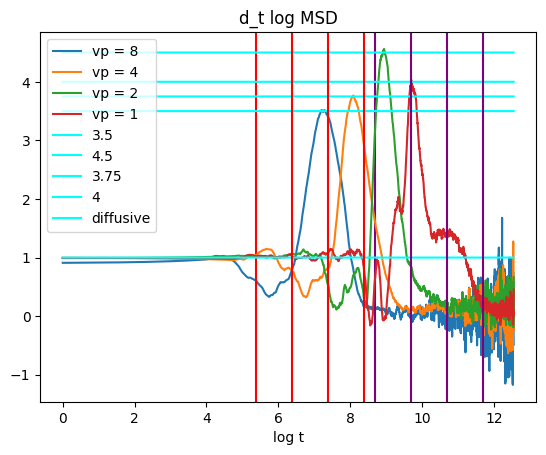

In [33]:
msd1 = (msd_500[:, 0] + msd_500[:, 1])[:6000]
msdp2 = msd_p2[:, 0] + msd_p2[:, 1]
msdp4 = msd_p4[:, 0] + msd_p4[:, 1]
msdp8 = msd_p8[:, 0] + msd_p8[:, 1]
x = np.log2(np.linspace(1, 6000, 6000))
y = np.log2(msdp8)
gradient = np.gradient(y, x)
smooth050 = savgol_filter(gradient, 31, 1)
plt.plot(x, smooth050, label='vp = 8')
plt.axvline(x=np.log2(333/8), color='r')
plt.axvline(x=np.log2(3333/8), color='purple')

y = np.log2(msdp4)
gradient = np.gradient(y, x)
smooth050 = savgol_filter(gradient, 53, 1)
plt.plot(x, smooth050, label='vp = 4')

y = np.log2(msdp2)
gradient = np.gradient(y, x)
smooth1 = savgol_filter(gradient, 53, 1)
plt.plot(x, smooth1, label='vp = 2')


y = np.log2(msd1)
gradient = np.gradient(y, x)
smooth075 = savgol_filter(gradient, 53, 1)
plt.plot(x, smooth075, label='vp = 1')



plt.plot(x, np.zeros(x.size)+3.5, label='3.5', color='cyan')
plt.plot(x, np.zeros(x.size)+4.5, label='4.5', color='cyan')
plt.plot(x, np.zeros(x.size)+3.75, label='3.75', color='cyan')
plt.plot(x, np.zeros(x.size)+4, label='4', color='cyan')
plt.plot(x, np.zeros(x.size)+1, label='diffusive', color='cyan')
plt.axvline(x=np.log2(333), color='r')
plt.axvline(x=np.log2(333/2), color='r')

plt.axvline(x=np.log2(333/4), color='r')
plt.axvline(x=np.log2(3333/4), color='purple')

plt.axvline(x=np.log2(3333/1), color='purple')
plt.axvline(x=np.log2(3333/2), color='purple')


plt.title('d_t log MSD')
plt.xlabel('log t')
plt.legend()
plt.show()

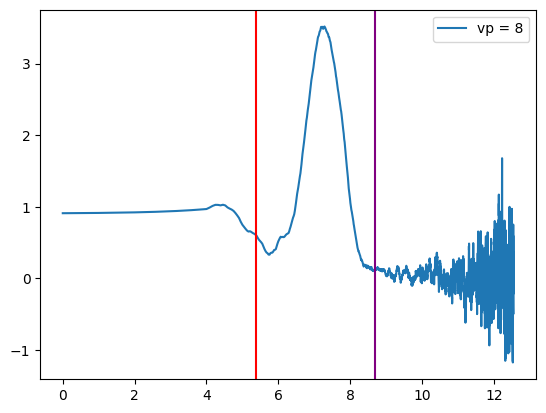

In [34]:
y = np.log2(msdp8)
gradient = np.gradient(y, x)
smooth050 = savgol_filter(gradient, 31, 1)
plt.plot(x, smooth050, label='vp = 8')
plt.axvline(x=np.log2(333/8), color='r')
plt.axvline(x=np.log2(3333/8), color='purple')
plt.legend()
plt.show()

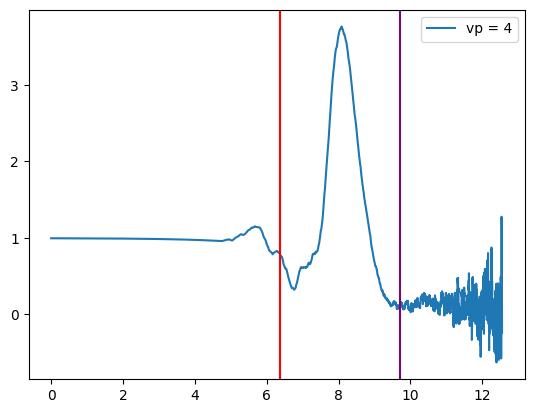

In [35]:
y = np.log2(msdp4)
gradient = np.gradient(y, x)
smooth050 = savgol_filter(gradient, 53, 1)
plt.plot(x, smooth050, label='vp = 4')
plt.axvline(x=np.log2(333/4), color='r')
plt.axvline(x=np.log2(3333/4), color='purple')
plt.legend()
plt.show()

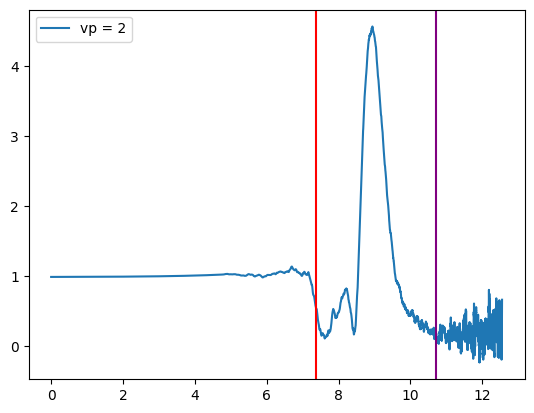

In [36]:
y = np.log2(msdp2)
gradient = np.gradient(y, x)
smooth1 = savgol_filter(gradient, 53, 1)
plt.plot(x, smooth1, label='vp = 2')
plt.axvline(x=np.log2(333/2), color='r')
plt.axvline(x=np.log2(3333/2), color='purple')
plt.legend()
plt.show()

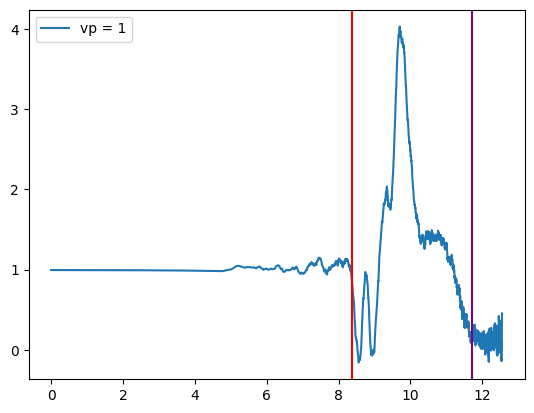

In [37]:
x = np.log2(np.linspace(1, 6000, 6000))
y = np.log2(msd1)
gradient = np.gradient(y, x)
smooth075 = savgol_filter(gradient, 53, 1)
plt.plot(x, smooth075, label='vp = 1')

plt.axvline(x=np.log2(333/1), color='r')
plt.axvline(x=np.log2(3333/1), color='purple')
plt.legend()
plt.show()

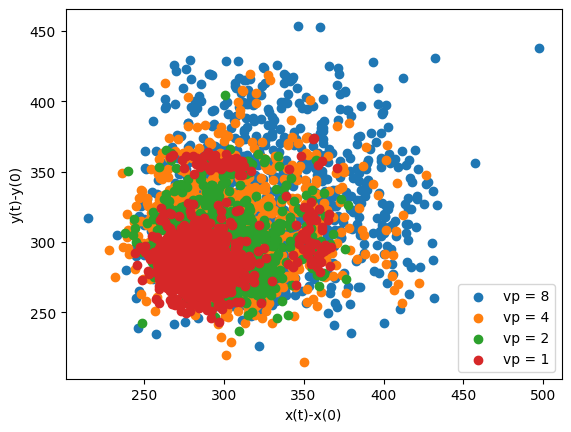

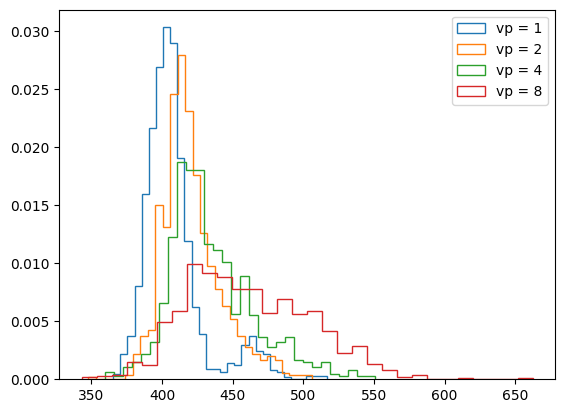

In [38]:
fin_500 = np.subtract(data_500[5999::8000], 500) # vd = 1
fin_p2 = np.subtract(data_p2[5999::6000], 500)
fin_p4 = np.subtract(data_p4[5999::6000], 500)
fin_p8 = np.subtract(data_p8[5999::6000], 500)

plt.scatter(fin_p8[:,0], fin_p8[:, 1], label='vp = 8')
plt.scatter(fin_p4[:,0], fin_p4[:, 1], label='vp = 4')
plt.scatter(fin_p2[:,0], fin_p2[:, 1], label='vp = 2')
plt.scatter(fin_500[:,0], fin_500[:, 1], label='vp = 1')

plt.xlabel('x(t)-x(0)')
plt.ylabel('y(t)-y(0)')
plt.legend()
plt.show()

plt.hist(np.linalg.norm(fin_500, axis=1), 30, density=True, histtype='step', label='vp = 1')
plt.hist(np.linalg.norm(fin_p2, axis=1), 30, density=True, histtype='step', label='vp = 2')
plt.hist(np.linalg.norm(fin_p4, axis=1), 30, density=True, histtype='step', label='vp = 4')
plt.hist(np.linalg.norm(fin_p8, axis=1), 30, density=True, histtype='step', label='vp = 8')
plt.legend()
plt.show()

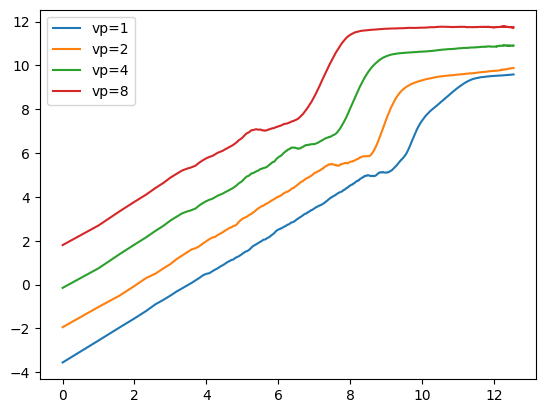

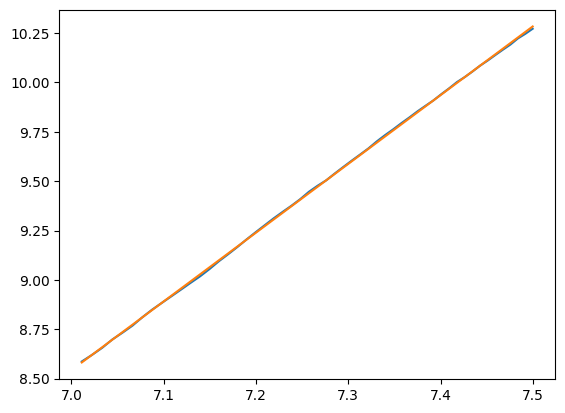

[  3.48277127 -15.83675071]


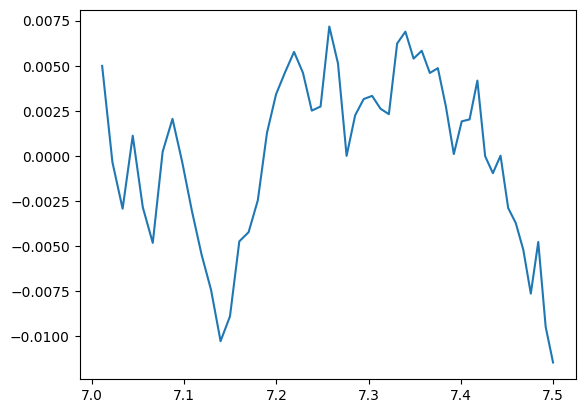

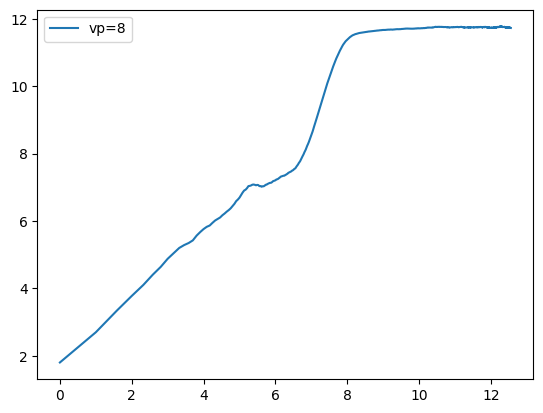

In [39]:
msd = (msd_500[:, 0] + msd_500[:, 1])[:6000]
x = np.log2(np.linspace(1, 6000, 6000))
y = np.log2(msd)
plt.plot(x, y, label='vp=1')

msd = msd_p2[:, 0] + msd_p2[:, 1]
x = np.log2(np.linspace(1, 6000, 6000))
y = np.log2(msd)
plt.plot(x, y, label='vp=2')

msd = msd_p4[:, 0] + msd_p4[:, 1]
x = np.log2(np.linspace(1, 6000, 6000))
y = np.log2(msd)
plt.plot(x, y, label='vp=4')

msd = msd_p8[:, 0] + msd_p8[:, 1]
x = np.log2(np.linspace(1, 6000, 6000))
y = np.log2(msd)
plt.plot(x, y, label='vp=8')
plt.legend()
plt.show()

msd = msd_p8[:, 0] + msd_p8[:, 1]
x = np.log2(np.linspace(1, 6000, 6000)[2**7:181])
y = np.log2(msd[2**7:181])
plt.plot(x, y, label='vp=8')
popt, pcov = curve_fit(line, x, y)
plt.plot(x, line(x, *popt))
plt.show()
plt.plot(x, y-line(x, *popt))
print(popt)
plt.show()
msd = msd_p8[:, 0] + msd_p8[:, 1]
x = np.log2(np.linspace(1, 6000, 6000))
y = np.log2(msd)
plt.plot(x, y, label='vp=8')

plt.legend()
plt.show()

In [40]:
data_l500 = np.loadtxt('./Data/com-l500.dat')

In [41]:
polar_test3 = np.loadtxt('./Data/polar-test3.dat')

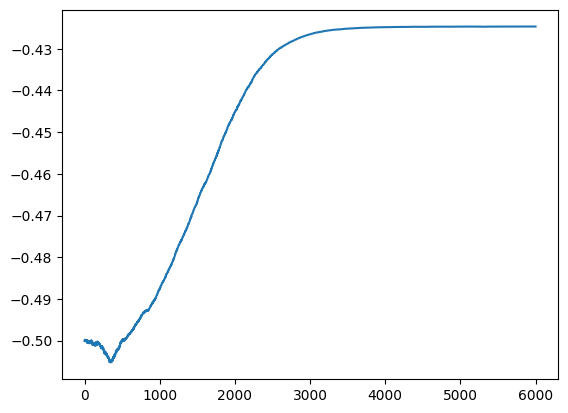

In [42]:
plt.plot(polar_test3[12000:18000]) #polar = 0 - Average over 5

In [43]:
polar_20 = np.loadtxt('./Data/polar-20.dat')

<AxesSubplot: >

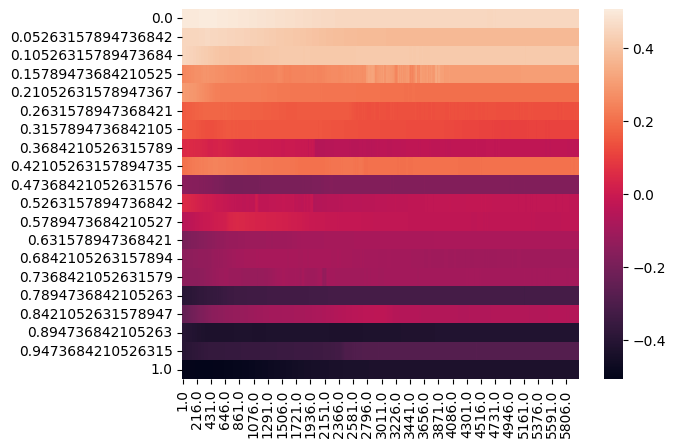

In [44]:
split = np.array_split(polar_20, 20)
idx = np.linspace(0, 1, 20)
time = np.linspace(1, 6000, 6000)
df = pd.DataFrame(split, index=idx, columns=time)
sns.heatmap(df)

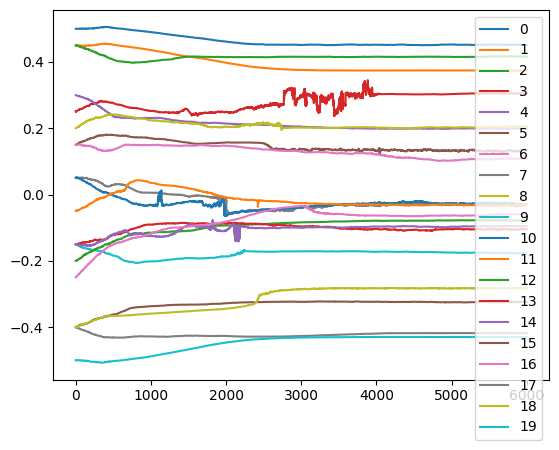

In [45]:
for i in range(20):
    plt.plot(split[i], label=i)
plt.legend()

In [46]:
force_test = np.loadtxt('./Data/force-128.dat')

(6000,)

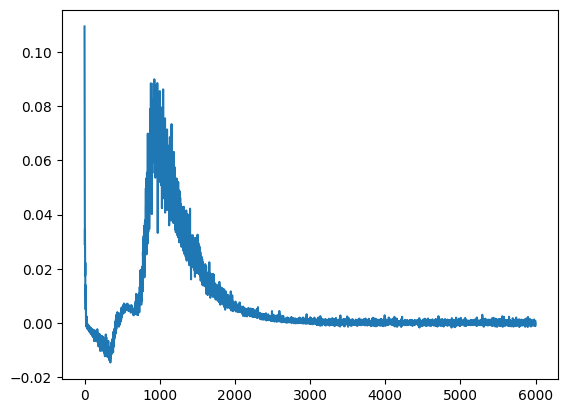

In [47]:
split = np.array_split(force_test, 128)
mean = np.mean(split, axis=0)
plt.plot(mean)
mean.shape

In [48]:
polar_d10 = np.loadtxt('./Data/polar-d10.dat')

<AxesSubplot: >

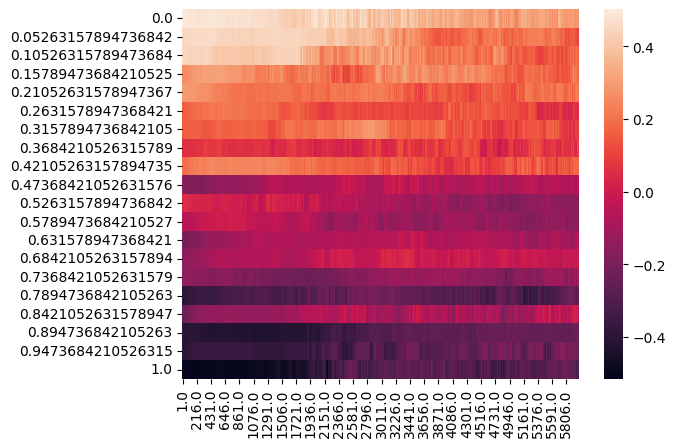

In [49]:
split = np.array(np.array_split(polar_d10, 20))
idx = np.linspace(0, 1, 20)
time = np.linspace(1, 6000, 6000)
df = pd.DataFrame(split, index=idx, columns=time)
sns.heatmap(df)

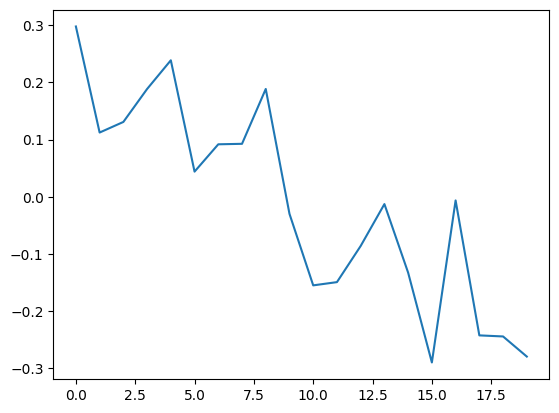

In [50]:
plt.plot(split[:, 5999])

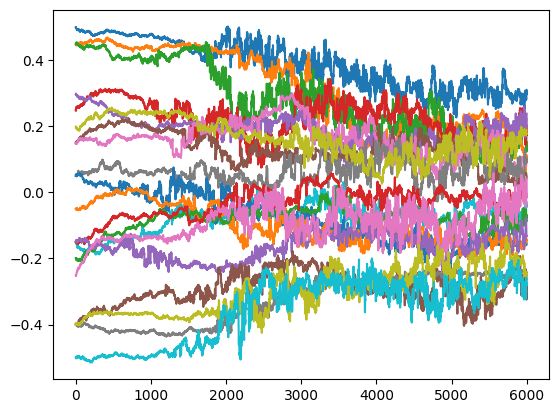

In [51]:
for i in range(20):
    plt.plot(split[i], label=i)